# Titanic - Machine Learning from Disaster

## Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle
from os import path
import dataframe_image as dfi

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import KMeansSMOTE
from scipy.stats import boxcox

# Models 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Model evaluation and selection
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Functions

#### Plot Confusion Matric and ROC Curve

In [2]:
# Plot Confusion Matrix and ROC Curve on the same row using one line

def model_assess(model, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    plot_confusion_matrix(model, X_test, y_test, ax=ax1)
    plot_roc_curve(model, X_test, y_test, ax=ax2)
    plt.tight_layout();

#### Pickling Function for Grid Search Results

In [3]:
# Pickle grid search results to save time


def create_or_load(file_name, fn, force=False):
    if path.exists(file_name) and not force:
        with open(file_name, 'rb') as f:
            return pickle.load(f)
    else:
        data = fn()
        with open(file_name, 'wb') as f:
            pickle.dump(data, f)
        return data

## Data Exploration

In [4]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.size

10692

In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
# Remove columns with very high numbers of categories that will cause too many dimensions for ML models
df = df.drop(['PassengerId','Name', 'Ticket'], axis=1)

In [8]:
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

### Get All Unique Values for Categorical Variables 

In [9]:
# change certain variables into categorial
df['Pclass'] = pd.Categorical(df['Pclass'])

# convert all object variables to catagorical variables
columns = df.select_dtypes(include=['object']).columns 
df[columns] = df[columns].astype('category')

In [10]:
# get a list of numerical columns
num = df.select_dtypes(include=np.number).columns.tolist()

# get a list of categorical variables
categorical_cols = list(set(df.columns)-set(num)) # get categorical column names
categorical_cols

['Sex', 'Cabin', 'Embarked', 'Pclass']

In [11]:
for i in range(len(categorical_cols)):
    print(categorical_cols[i])
    print(df[categorical_cols[i]].unique())
    print(' ')

Sex
['male', 'female']
Categories (2, object): ['female', 'male']
 
Cabin
[NaN, 'C85', 'C123', 'E46', 'G6', ..., 'E17', 'A24', 'C50', 'B42', 'C148']
Length: 148
Categories (147, object): ['A10', 'A14', 'A16', 'A19', ..., 'F38', 'F4', 'G6', 'T']
 
Embarked
['S', 'C', 'Q', NaN]
Categories (3, object): ['C', 'Q', 'S']
 
Pclass
[3, 1, 2]
Categories (3, int64): [1, 2, 3]
 


### Identify Missing Values

In [12]:
# check for NAs
df.isnull().values.any()

True

In [13]:
# How many NAs are there
df.isnull().sum().sum()

866

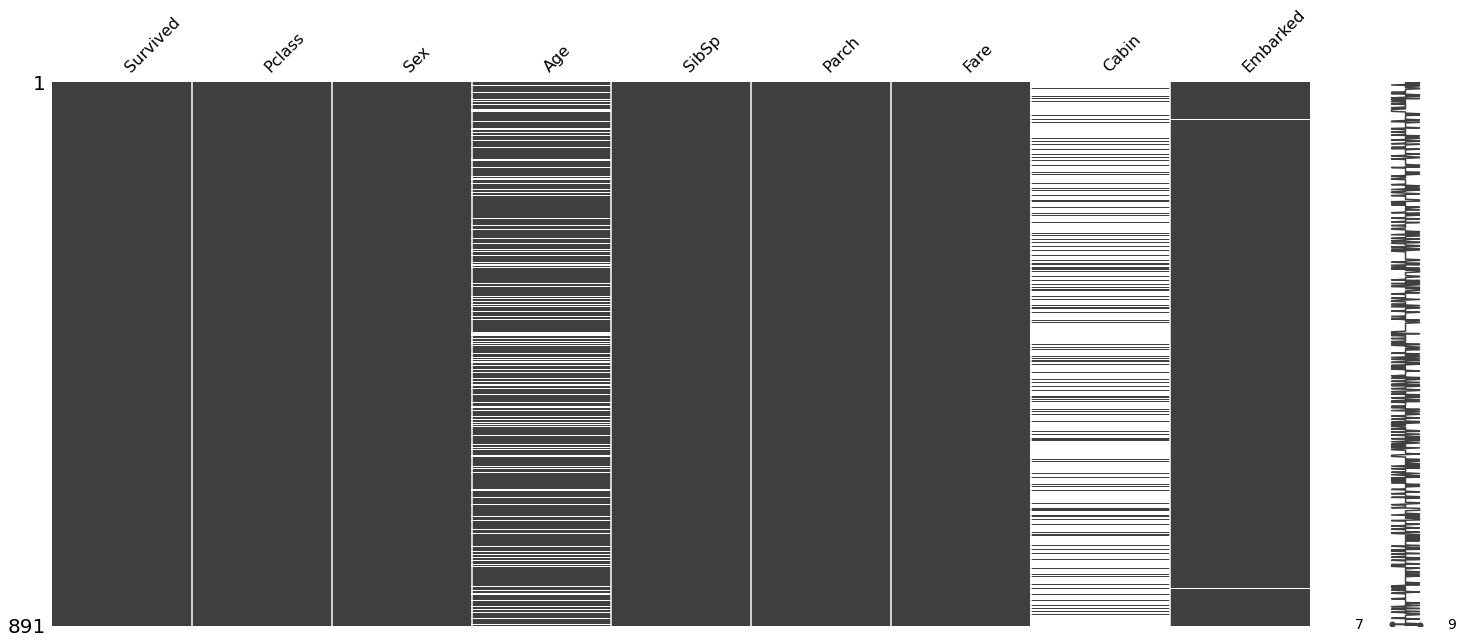

In [14]:
# Lets check where the NaNs are coming from
msno.matrix(df);

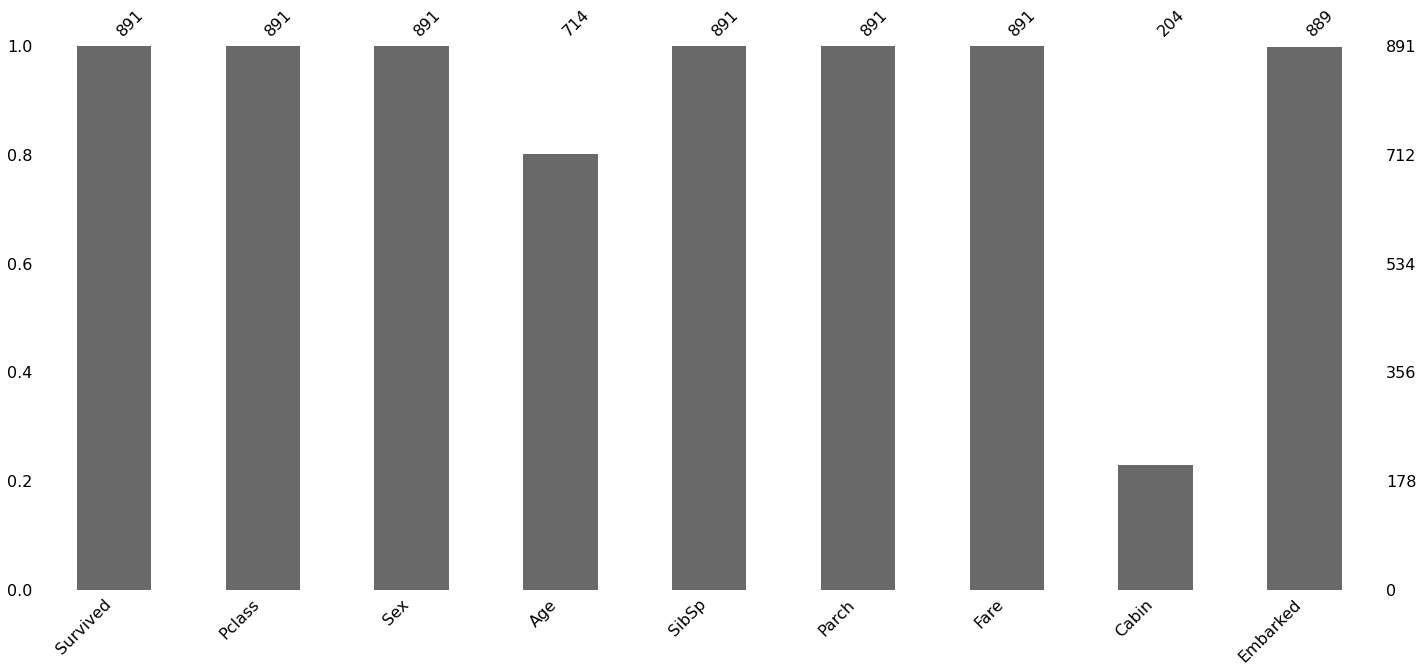

In [15]:
msno.bar(df);

In [16]:
# Remove cabin variable because it has too many missing values
df = df.drop(['Cabin'], axis=1)

### Impute the missing values of passengers

We can't remove the rows of the passengers because we want to create a model that can predict survival on data with missing ages as well. 

#### Add the median age for missing passengers

In [17]:
# get median age
median_age = df.Age.median()

# for all missing values, replace with median age
df.Age = np.nan_to_num(df.Age, nan=median_age)

#### Add most frequent embarkment for missing passengers

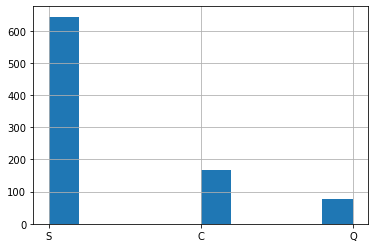

In [18]:
df['Embarked'].hist();

In [19]:
most_freq = df['Embarked'].value_counts().idxmax()
df.Embarked = df.Embarked.fillna(most_freq)

#### Check NaNs

In [20]:
# check for NAs
df.isnull().values.any()

False

### Visualise Data

In [21]:
# get a list of numerical columns
num = df.select_dtypes(include=np.number).columns.tolist()
num

['Survived', 'Age', 'SibSp', 'Parch', 'Fare']

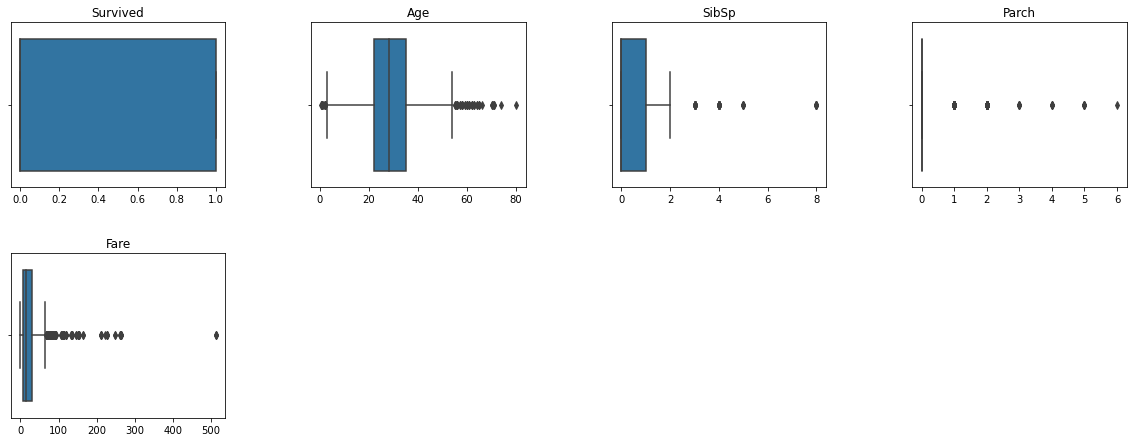

In [22]:
# create boxplots for all numerical columns
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4);

sns.boxplot(x=df.iloc[:,0])

for i in range(1,len(num)+1):
    plt.subplot(5, 4, i)
    ax = sns.boxplot(x=df[num[i-1]]) # have to subtract 1 because iterations begin at 1
    ax.set(xlabel=None);
    ax.set_title(num[i-1]);

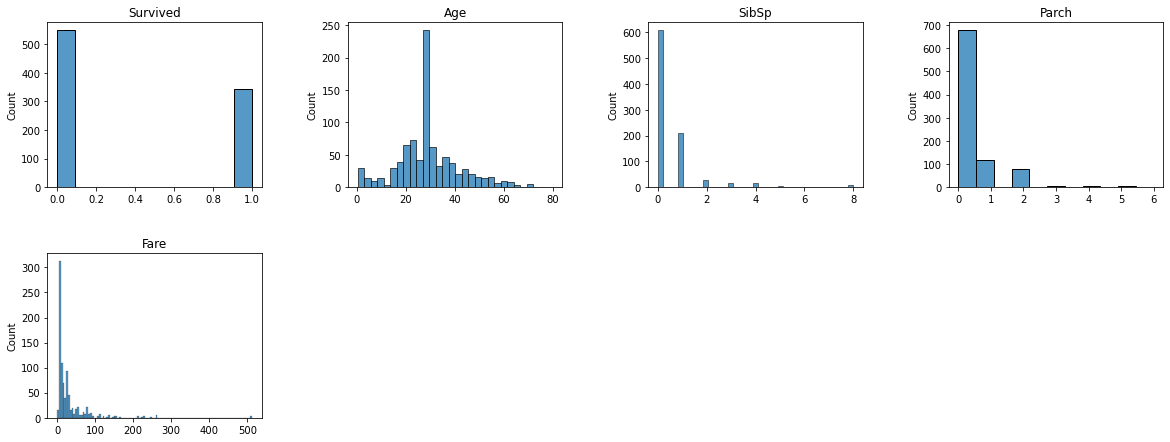

In [23]:
# lets look at the skew for each numerical variable
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4);

for i in range(1,len(num)+1):
    plt.subplot(5, 4, i)
    ax = sns.histplot(x=df[num[i-1]]) # have to subtract 1 because iterations begin at 1
    ax.set(xlabel=None);
    ax.set_title(num[i-1]);

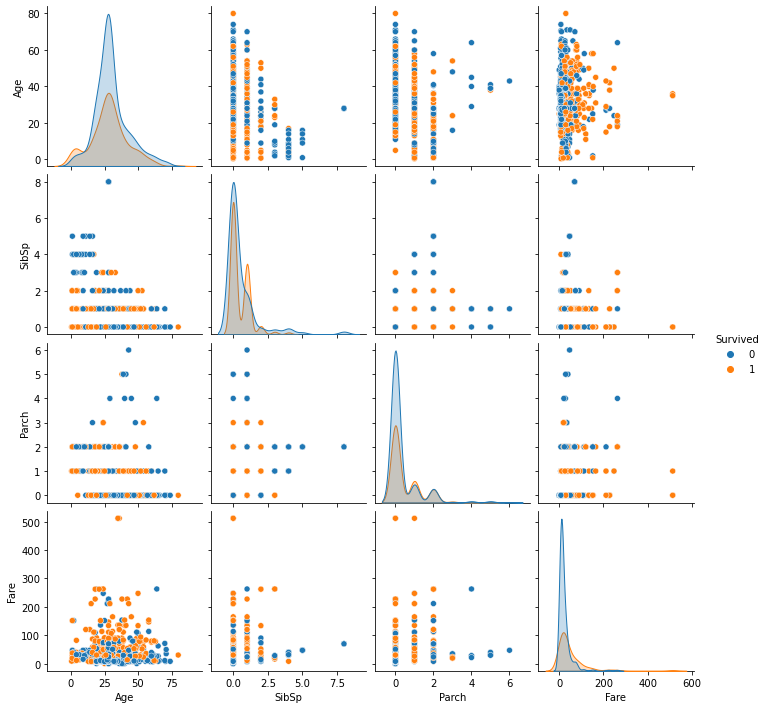

In [24]:
# Scatter plot matrix
df['Survived'] = pd.Categorical(df['Survived'])
sns.pairplot(df, hue="Survived");

### Make Dummy Variables for Categoricals

In [25]:
df.dtypes

Survived    category
Pclass      category
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked    category
dtype: object

In [26]:
# Change survived, Pclass back to numerical
df[['Survived','Pclass']] = df[['Survived','Pclass']].apply(pd.to_numeric)

In [27]:
# generate binary values
df_enc = pd.get_dummies(df, columns=['Sex', 'Embarked'])
df_enc.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


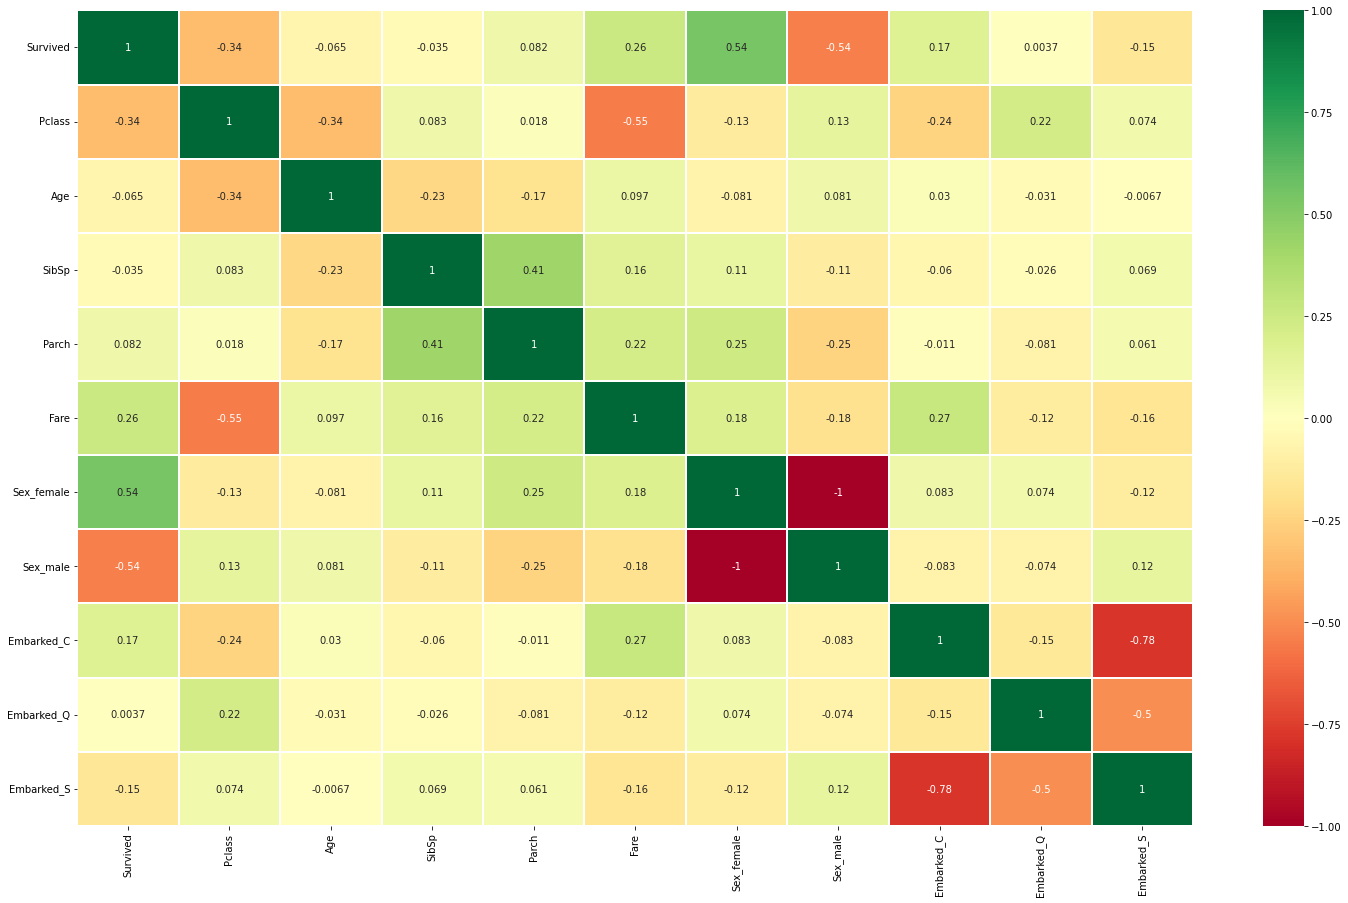

In [28]:
# Correlation plot
sns.heatmap(df_enc.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(25,15)
plt.show()

### Split Data into Training and Test Sets

In [29]:
# check rato of survivers to non-survivors
df_enc.groupby('Survived').size()

Survived
0    549
1    342
dtype: int64

There are roughly twice as many non-survivors as survivors. This ratio must be maintained between training and test sets, which will be achieved through stratified sampling. 

In [30]:
# Get X and y variables
X = df_enc.drop(['Survived'], axis=1)
y = df_enc['Survived']

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

X_train = np.asarray(X_train)
X_test  = np.asarray(X_test)

In [31]:
# check traning set
unique, counts = np.unique(y_train, return_counts=True)
np.asarray((unique, (counts/len(y_train))*100)).T

array([[ 0.        , 61.57718121],
       [ 1.        , 38.42281879]])

In [32]:
# check test set
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, (counts/len(y_test))*100)).T

array([[ 0.        , 61.69491525],
       [ 1.        , 38.30508475]])

### Scale Training and Test Data

In [33]:
# transform training and test sets seperatly
scaler = StandardScaler()

# we want to only scale the non-encoded variables which are the first 5 columns
train = scaler.fit_transform(pd.DataFrame(X_train).iloc[:,:5])
test = scaler.fit_transform(pd.DataFrame(X_test).iloc[:,:5])

# join together encoded and non-encoded variables
X_train = np.concatenate((train,np.delete(X_train, np.s_[0:5], axis=1)),axis=1)
X_test = np.concatenate((test,np.delete(X_test, np.s_[0:5], axis=1)),axis=1)

### Balance Survival Variable using KMeansSMOTE

In [34]:
sm = KMeansSMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

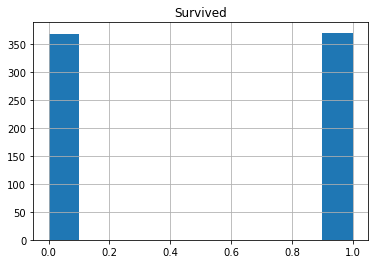

In [35]:
pd.DataFrame(y_train).hist();

### Create a Table to Compare Models

In [36]:
assess_table = pd.DataFrame(columns=['Model Name','F1 Perished','F1 Survived','Accuracy'])

## Logistic Regression

In [37]:
# Initialize model
logmodel = LogisticRegression()
# fit model to data
logmodel.fit(X_train,y_train)

LogisticRegression()

### Assess Model Preformance

#### Confusion Matrix and AUC Curve

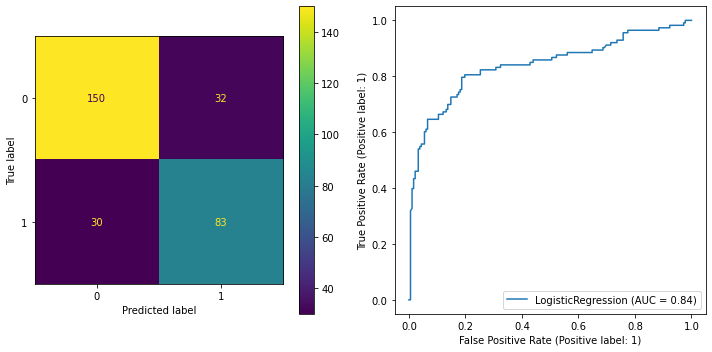

In [38]:
model_assess(logmodel, X_test, y_test)

The confusion matric indicates that the logistic regression model did a pretty good job at predcting those who did not survived versus those who did survive. It successfully predicted 116 non-survivors and 69 survivors and only mislabeled 26 survivors as non-survived and 24 non-survivors who in fact did survive.  

ROC is a probability curve and AUC is the degree of measure of seperability and both indicate how well the model is at seperating the classes. The higher the AUC value, the better the model is at predicting the target variable. The AUC value for the logistic regression model is 0.85, which is close to 1 indicating that the model performs quite well at distinguishing between survivors and non-survivors. The steep curve of the ROC also reveals that the model is good at seperating survivors from non-survivors. A linear diagonal line would indicate that the model could not seperate the groups at all. 

The target variable in this dataset is unbalanced (Much more non-survivors than survivors) and we, therefore, should consider the f1 scores for each class to determine how well the model did. 

#### Accuracy, Recall, Precision and F1 score

In [39]:
predictions = logmodel.predict(X_test)
# add results to assess_table
report = classification_report(y_test, predictions, output_dict=True )
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       182
           1       0.72      0.73      0.73       113

    accuracy                           0.79       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



In [40]:
# append results to table
assess_table = assess_table.append({'Model Name':type(logmodel).__name__,
                     'F1 Perished':round(report['0']['f1-score'],2), 
                     'F1 Survived':round(report['1']['f1-score'],2), 
                     'Accuracy':round(report['accuracy'],2)}, ignore_index=True)

The f1 score is the harmonic mean between precision and recall. The logistic regression model is much better at predicting individuals who did not survive (f1 = 0.82) the titanic than those that did survive (f1 = 0.73). The overall accuracy is 0.79 for the logistic regression model. 

## K-neighbors Classification

In [41]:
# Initialize model
knn = KNeighborsClassifier(n_neighbors=2)
# fit model to data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

### Assess Model Preformance

#### Confusion Matrix and ROC

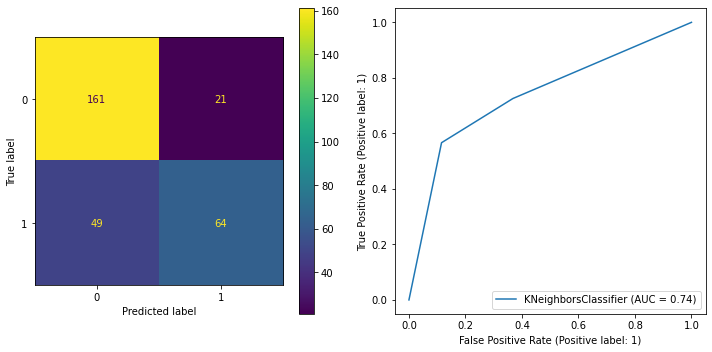

In [42]:
model_assess(knn, X_test, y_test);

#### Accuracy, Recall, Precision and F1 score

In [43]:
predictions = knn.predict(X_test)
report = classification_report(y_test, predictions, output_dict=True )
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       182
           1       0.75      0.57      0.65       113

    accuracy                           0.76       295
   macro avg       0.76      0.73      0.73       295
weighted avg       0.76      0.76      0.75       295



The K-nearest neighbors classifier did a very poor job at successfully predicting survivors (f1-score = 0.66).  

In [44]:
# append results to table
assess_table = assess_table.append({'Model Name':type(knn).__name__,
                     'F1 Perished':round(report['0']['f1-score'],2), 
                     'F1 Survived':round(report['1']['f1-score'],2), 
                     'Accuracy':round(report['accuracy'],2)}, ignore_index=True)

assess_table.sort_values(['Accuracy'], ascending = False)

,Model Name,F1 Perished,F1 Survived,Accuracy
0,LogisticRegression,0.83,0.73,0.79
1,KNeighborsClassifier,0.82,0.65,0.76


## Support Vector Machines 

### Tune Hyperparameters

In [45]:
def svc_gridsearch():
    param_grid = {'C': [0.1,1, 10, 100], 
                  # 'gamma': [1,0.1,0.01,0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid','linear']}

    # search parameters
    grid = GridSearchCV(svm.SVC(), param_grid)

    # fit model
    return grid.fit(X_train, y_train)

In [46]:
# pickle the grid search reslts
svc_grid = create_or_load('svc.pickle', svc_gridsearch)

In [47]:
# get the best parameters
print(svc_grid.best_estimator_)

SVC(C=1)


### Assess Model Preformance

#### Confusion Matrix and ROC

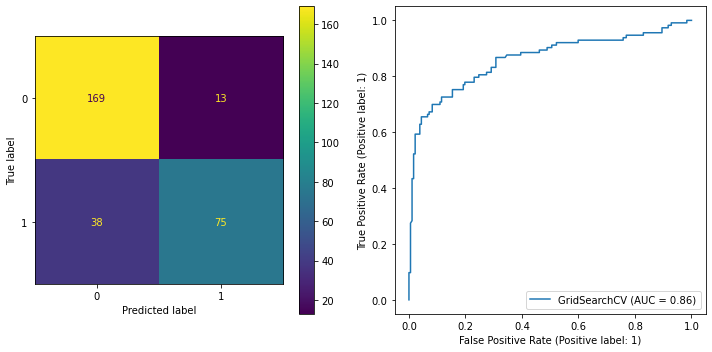

In [48]:
model_assess(svc_grid, X_test, y_test);

#### Accuracy, Recall, Precision and F1 score

In [49]:
predictions = svc_grid.predict(X_test)
report = classification_report(y_test, predictions, output_dict=True )
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       182
           1       0.85      0.66      0.75       113

    accuracy                           0.83       295
   macro avg       0.83      0.80      0.81       295
weighted avg       0.83      0.83      0.82       295



In [50]:
# append results to table
assess_table = assess_table.append({'Model Name':'SupportVectorClassifier',
                     'F1 Perished':round(report['0']['f1-score'],2), 
                     'F1 Survived':round(report['1']['f1-score'],2), 
                     'Accuracy':round(report['accuracy'],2)}, ignore_index=True)

assess_table.sort_values(['Accuracy'], ascending = False)

,Model Name,F1 Perished,F1 Survived,Accuracy
2,SupportVectorClassifier,0.87,0.75,0.83
0,LogisticRegression,0.83,0.73,0.79
1,KNeighborsClassifier,0.82,0.65,0.76


## Random Forest

### Tune Random Forest

In [51]:
# initialise model
rfc = RandomForestClassifier()

def rfc_gridsearch():

    # Define parameters
    n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 5)] # number of trees
    max_features = ['auto','sqrt'] # number of features at every split
    max_depth = [int(x) for x in np.linspace(700, 950, num = 5)] # max depth
    max_depth.append(None)
    class_weight = [None,'balanced','balanced_subsample'] # class weight

    # Create parameter grid
    param_grid = {'n_estimators':n_estimators,
                   'max_features':max_features,
                   'max_depth':max_depth,
                  'class_weight':class_weight}

    # search parameters
    grid = GridSearchCV(rfc, param_grid)

    # fit model
    return grid.fit(X_train, y_train)

In [52]:
# pickle the grid search reslts
rfc_grid = create_or_load('rfc.pickle', rfc_gridsearch)

In [53]:
# get the best parameters
print(rfc_grid.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=950, n_estimators=500)


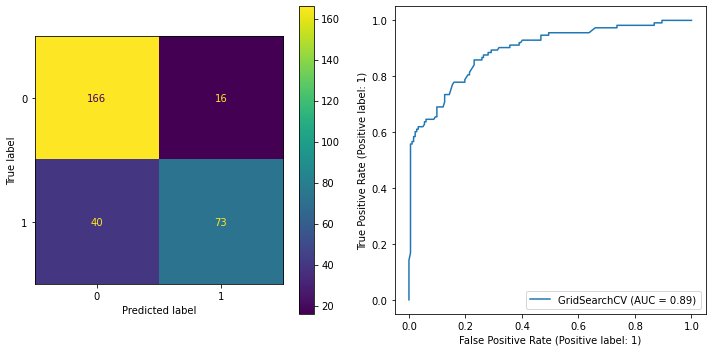

In [54]:
# plug best parameters into our model and run again
model_assess(rfc_grid, X_test, y_test);

In [55]:
predictions = rfc_grid.predict(X_test)
report = classification_report(y_test, predictions, output_dict=True )
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       182
           1       0.82      0.65      0.72       113

    accuracy                           0.81       295
   macro avg       0.81      0.78      0.79       295
weighted avg       0.81      0.81      0.80       295



In [56]:
# append results to table
assess_table = assess_table.append({'Model Name':'RandomForest',
                     'F1 Perished':round(report['0']['f1-score'],2), 
                     'F1 Survived':round(report['1']['f1-score'],2), 
                     'Accuracy':round(report['accuracy'],2)}, ignore_index=True)

assess_table.sort_values(['Accuracy'], ascending = False)

,Model Name,F1 Perished,F1 Survived,Accuracy
2,SupportVectorClassifier,0.87,0.75,0.83
3,RandomForest,0.86,0.72,0.81
0,LogisticRegression,0.83,0.73,0.79
1,KNeighborsClassifier,0.82,0.65,0.76


## Deep Learning

In [57]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs. 
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

In [58]:
# build model
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 1,647
Trainable params: 1,647
Non-trainable params: 0
_________________________________________________________________


2021-10-13 11:39:48.351635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 11:39:48.351965: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [59]:
# now we just update our model fit call
history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/80


2021-10-13 11:39:48.437323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


59/59 [==============================] - 1s 8ms/step - loss: 0.6136 - accuracy: 0.6418 - val_loss: 0.7540 - val_accuracy: 0.1892
Epoch 2/80
59/59 [==============================] - 0s 4ms/step - loss: 0.5166 - accuracy: 0.7725 - val_loss: 0.5536 - val_accuracy: 0.9122
Epoch 3/80
59/59 [==============================] - 0s 4ms/step - loss: 0.4603 - accuracy: 0.8149 - val_loss: 0.3948 - val_accuracy: 0.9122
Epoch 4/80
59/59 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.8048 - val_loss: 0.3125 - val_accuracy: 0.9054
Epoch 5/80
59/59 [==============================] - 0s 4ms/step - loss: 0.4175 - accuracy: 0.8183 - val_loss: 0.2328 - val_accuracy: 0.9257
Epoch 6/80
59/59 [==============================] - 0s 6ms/step - loss: 0.4086 - accuracy: 0.8217 - val_loss: 0.2340 - val_accuracy: 0.9257
Epoch 7/80
59/59 [==============================] - 0s 5ms/step - loss: 0.3995 - accuracy: 0.8166 - val_loss: 0.2442 - val_accuracy: 0.9189
Epoch 8/80
59/59 [=============

In [60]:
predictions = np.round(model.predict(X_test),0)
report = classification_report(y_test, predictions, output_dict=True )
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       182
           1       0.73      0.72      0.72       113

    accuracy                           0.79       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



In [61]:
# append results to table
assess_table = assess_table.append({'Model Name':'Deep Learning',
                     'F1 Perished':round(report['0']['f1-score'],2), 
                     'F1 Survived':round(report['1']['f1-score'],2), 
                     'Accuracy':round(report['accuracy'],2)}, ignore_index=True)

assess_table = assess_table.sort_values(['Accuracy','F1 Survived'], ascending = False)

### Export Table

In [75]:
dfi.export(assess_table, 'models.png')

[1013/114024.594865:WARNING:vaapi_wrapper.cc(586)] VAAPI video acceleration not available for swiftshader
[1013/114024.595045:ERROR:gpu_init.cc(453)] Passthrough is not supported, GL is swiftshader, ANGLE is 
[1013/114024.719855:INFO:headless_shell.cc(653)] Written to file /tmp/tmpoizyawli/temp.png.


## Use Best Model to Predict Test Data

#### Load in Data

In [63]:
# import data
test = pd.read_csv('test.csv')

# retrieve the passenger IDs
PassengerId = test.PassengerId

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### Clean Data

In [64]:
# Remove Columns
test = test.drop(['PassengerId','Name', 'Ticket','Cabin'], axis=1)

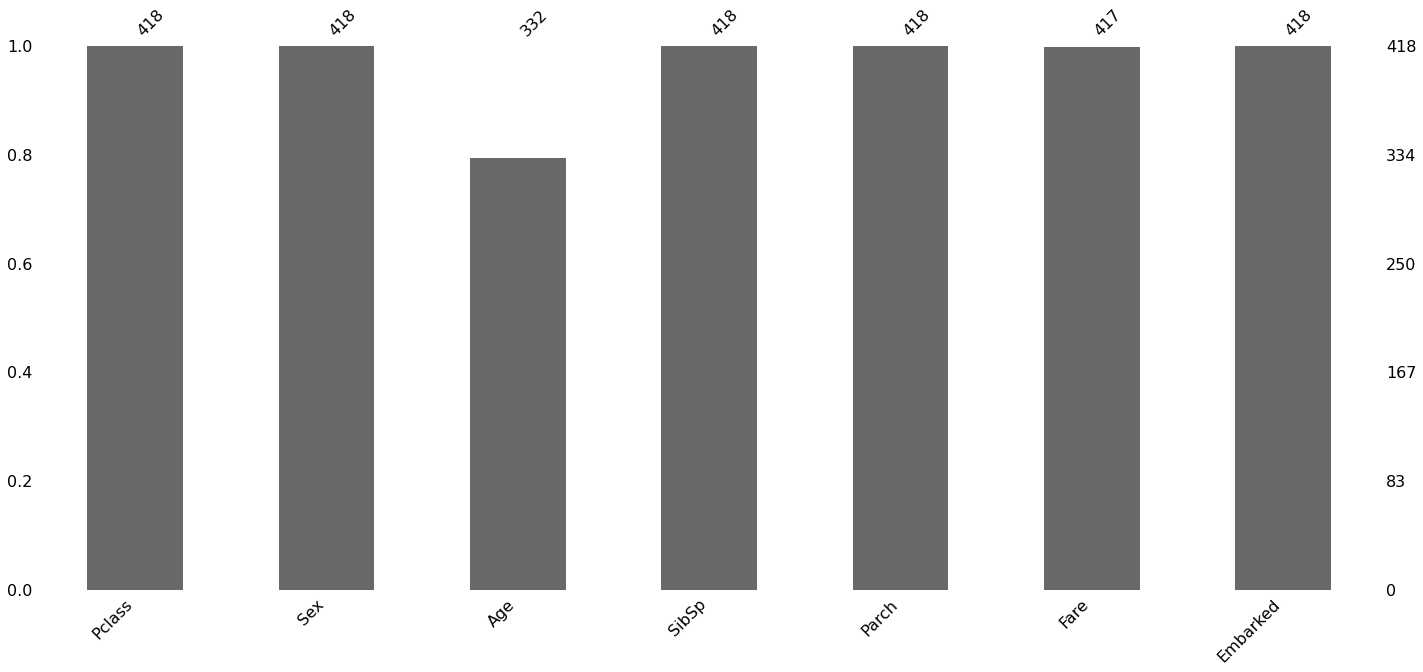

In [65]:
msno.bar(test);

In [66]:
# replace NaNs in age with median value
median_age = test.Age.median()
test.Age = np.nan_to_num(test.Age, nan=median_age)

# replace NaNs in Fare with median value
median_fare = test.Fare.median()
test.Fare = np.nan_to_num(test.Fare, nan=median_fare)

In [67]:
# check for NAs
test.isnull().values.any()

False

In [68]:
# encode categorical variables 
test.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [69]:
# generate binary values for categorical variables
test = pd.get_dummies(test, columns=['Sex', 'Embarked'])

In [70]:
# scale columns that were not encoded
test_array = test.to_numpy()
# test_columns = test.columns

# we want to only scale the non-encoded variables which are the first 5 columns
test_scaled = scaler.fit_transform(pd.DataFrame(test_array).iloc[:,:5])

# join together encoded and non-encoded variables
test = np.concatenate((test_scaled, np.delete(test_array, np.s_[0:5], axis=1)),axis=1)

# make into dataframe
# pd.DataFrame(test, columns= test_columns)

In [71]:
# Predict the survival column
survival = svc_grid.predict(test)
survival

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [72]:
len(survival)

418

### Export Results

Submission File Format:

You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

    - PassengerId (sorted in any order)
    - Survived (contains your binary predictions: 1 for survived, 0 for deceased)

In [73]:
results = pd.DataFrame(np.column_stack([PassengerId, survival]), columns=['PassengerId','Survived'])
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [74]:
# export to csv
results.to_csv('results.csv', sep=',', header=True, index=False)